# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. 

Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto

1. Descarga los datos y remuestréalos de tal forma que cada punto de datos de los datos originales caigan dentro de intervalos de una hora.
2. Analiza los datos.
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.
4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de datos

Los datos se almacenan en el archivo /datasets/taxi.csv.  Descarga el conjunto de datos

El número de pedidos está en la columna num_orders.

## Evaluación del proyecto

Hemos definido los criterios de evaluación para el proyecto. Léelos con atención antes de pasar al ejercicio.

Esto es en lo que se fijarán los revisores al examinar tu proyecto:

¿Seguiste todos los pasos de las instrucciones?
¿Cómo preparaste los datos?
¿Qué modelos e hiperparámetros consideraste?
¿Conseguiste evitar la duplicación del código?
¿Cuáles fueron tus hallazgos?
¿Mantuviste la estructura del proyecto?
¿Mantuviste el código limpio?


# 1. Exploración de datos

## 1.1. Importación de librerías

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error,  mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor





## 1.2 Carga de datos

In [9]:
data = pd.read_csv('./datasets/taxi.csv',index_col=[0],parse_dates = ['datetime'])


/tmp/ipykernel_50774/2905848432.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.resample('1H').sum()


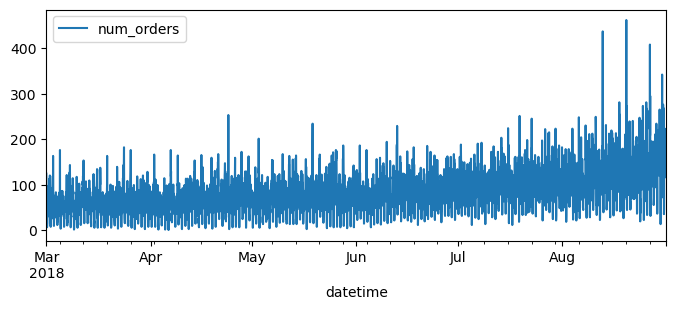

In [10]:
#print(data.index.is_monotonic)
data = data.resample('1H').sum()
fig, ax = plt.subplots(figsize=(8, 3))
data.plot(ax=ax)
plt.show()

<div class="alert alert-block alert-info">
<b>

26496 registros de pedidos de taxi en el aeropuerto. 

Los registros están ordenados cronológicamente, 

cada 10 minutos desde 2018-03-01 hasta 2018-08-31.

1. Se convirtieron a formato datetime.
2. Se agruparon por hora.

</b></div>

## 1.3 Tendencias y estacionalidad

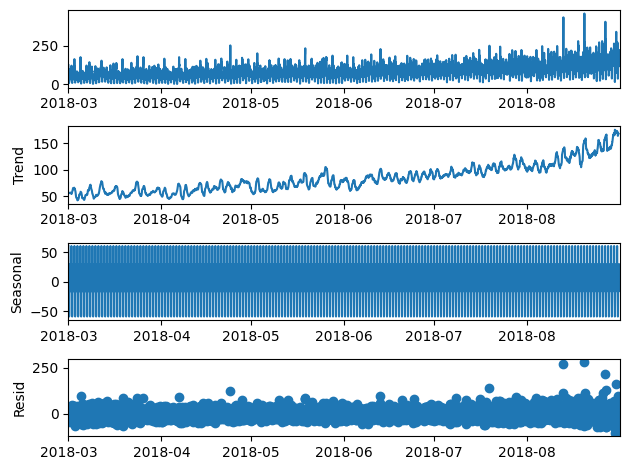

In [5]:
result=seasonal_decompose(data, model='additive')
result.plot()
plt.show()

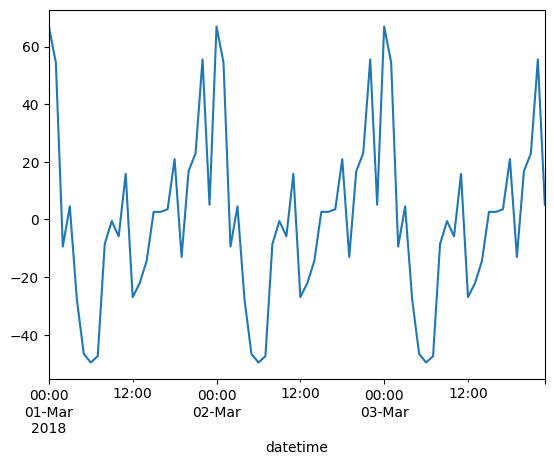

In [6]:
data_hour = data['2018-03-01 00:00:00':'2018-03-03 23:00:00']
decomposed_hour = seasonal_decompose(data_hour)
decomposed_hour.seasonal.plot()
plt.show()

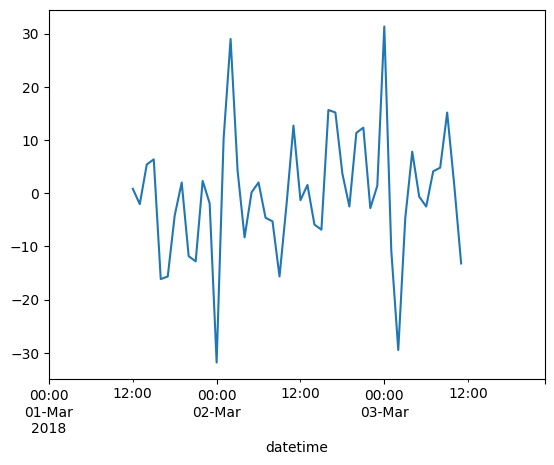

In [7]:
decomposed_hour.resid.plot()
plt.show()


<div class="alert alert-block alert-info">
<b>

1. Tendencia: aumento en la cantidad de pedidos de taxi durante el período de estudio.
2. Estacionalidad: aumento en la cantidad de pedidos de taxi durante la noche.
3. Residuos: Mayor variabilidad en la cantidad de pedidos de taxi durante la noche.


## 1.4 Estadísticas


In [8]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


<AxesSubplot:xlabel='datetime'>

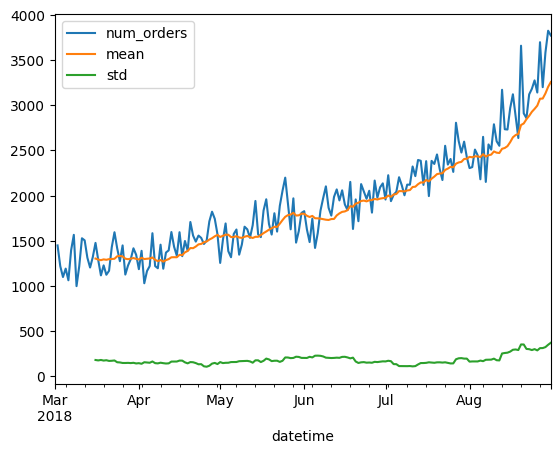

In [9]:
data5 = data['2018-03':'2018-08'].resample('1D').sum()
data5 -= data.shift()
data5['mean'] = data5['num_orders'].rolling(15).mean()
data5['std'] = data5['num_orders'].rolling(15).std()
data5.plot()


<div class="alert alert-block alert-info">

1. La cantidad promedio de pedidos de taxi por hora es de 84.

2. La desviación estándar de la cantidad de pedidos de taxi por hora es de 45.

3. La cantidad mínima de pedidos de taxi por hora es de 0.

4. La cantidad máxima de pedidos de taxi por hora es de 462.

<b>


In [10]:
# nuevas características
data['day'] = data.index.day
data['hour'] = data.index.hour
data['weekday'] = data.index.weekday
data['month'] = data.index.month


In [11]:
print('Mes con mas ordenes:', data.groupby(data.index.month).sum()['month'].idxmax())
print('Dia del mes con mas ordenes:', data.groupby(data.index.day).sum()['day'].idxmax())
print('Hora con mas ordenes:', data.groupby(data.index.hour).sum()['hour'].idxmax())
print('Dia de la semana con mas ordenes:', data.groupby(data.index.weekday).sum()['weekday'].idxmax())

Mes con mas ordenes: 8
Dia del mes con mas ordenes: 30
Hora con mas ordenes: 23
Dia de la semana con mas ordenes: 6


Text(0.5, 1.0, 'Number of Orders by Day')

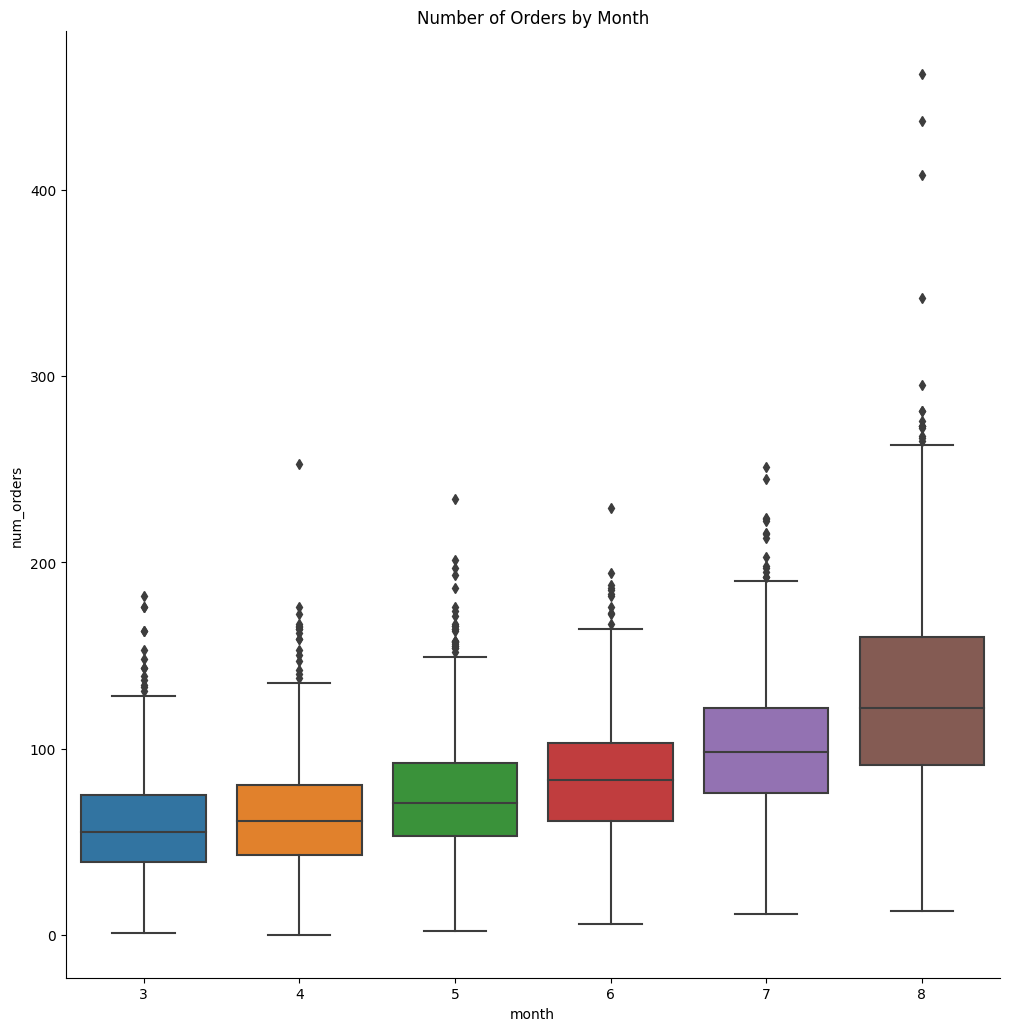

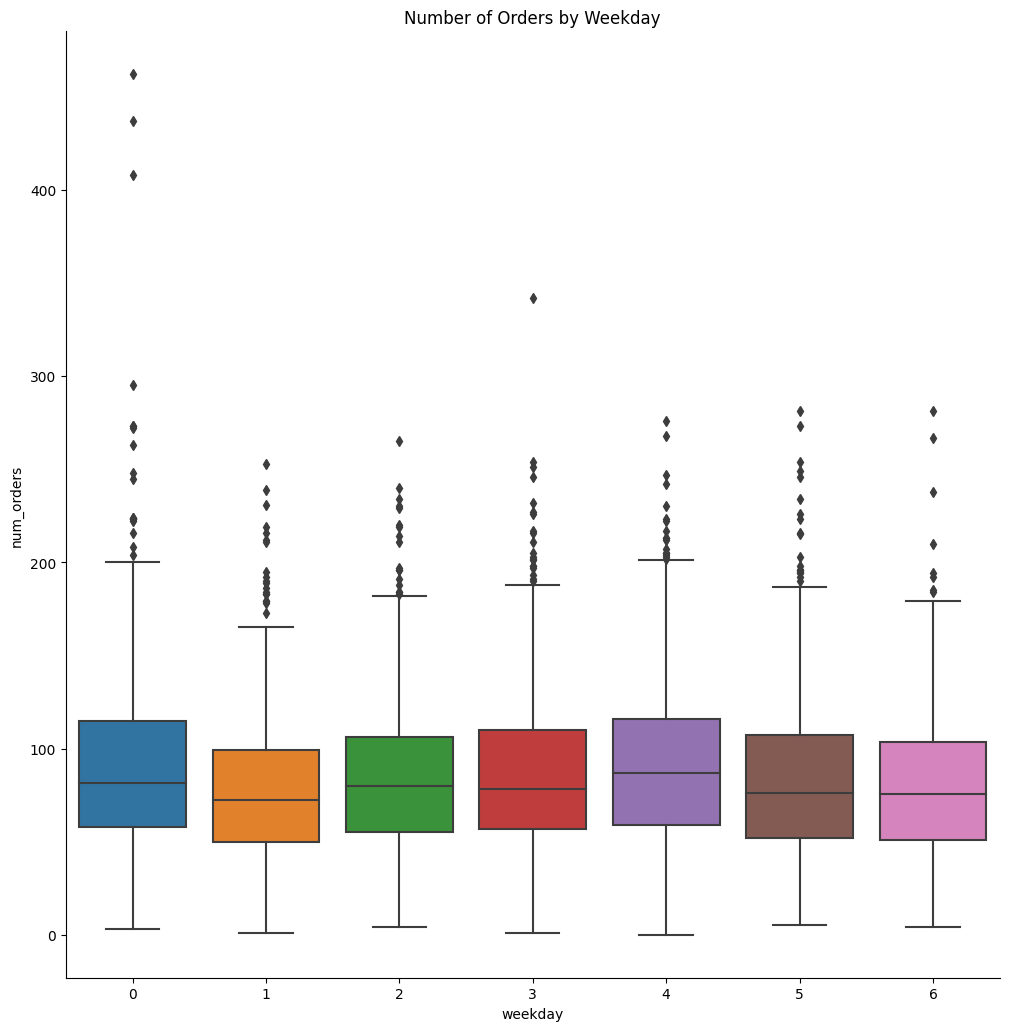

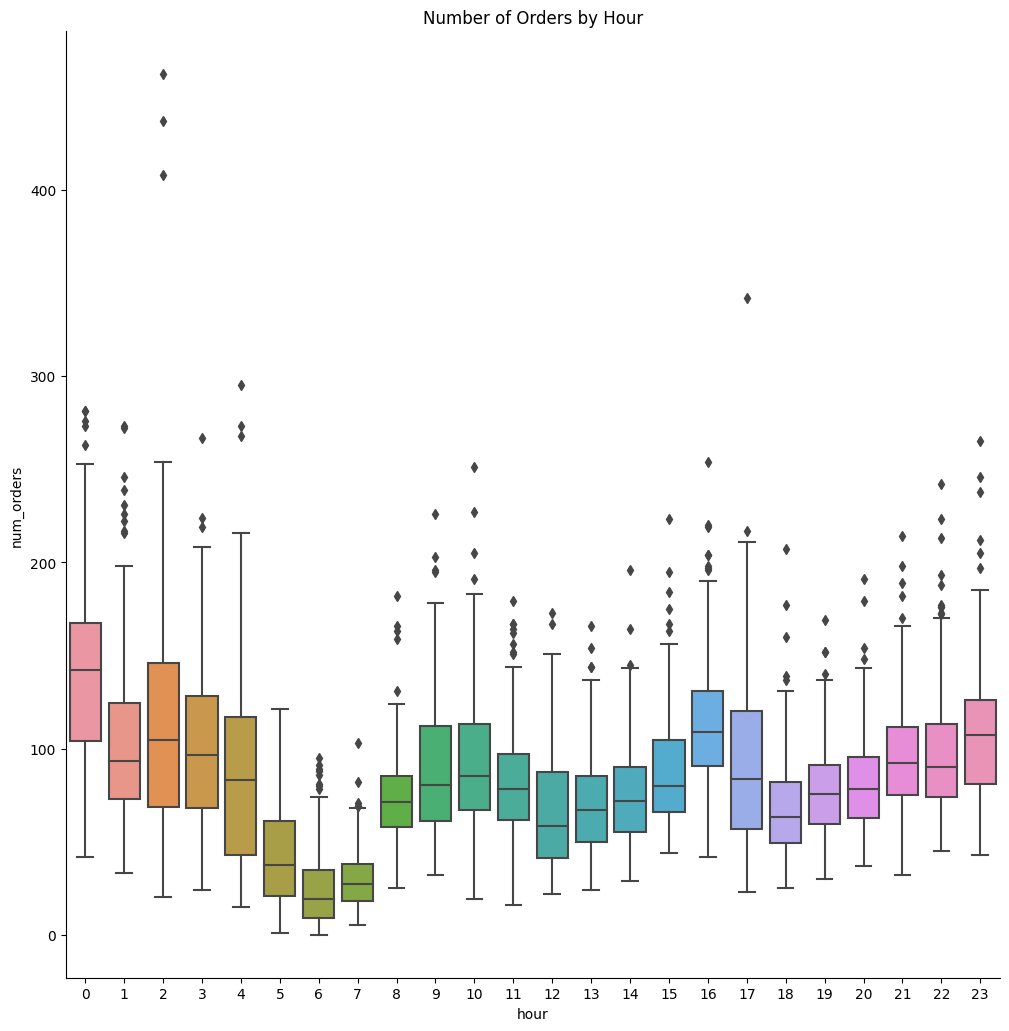

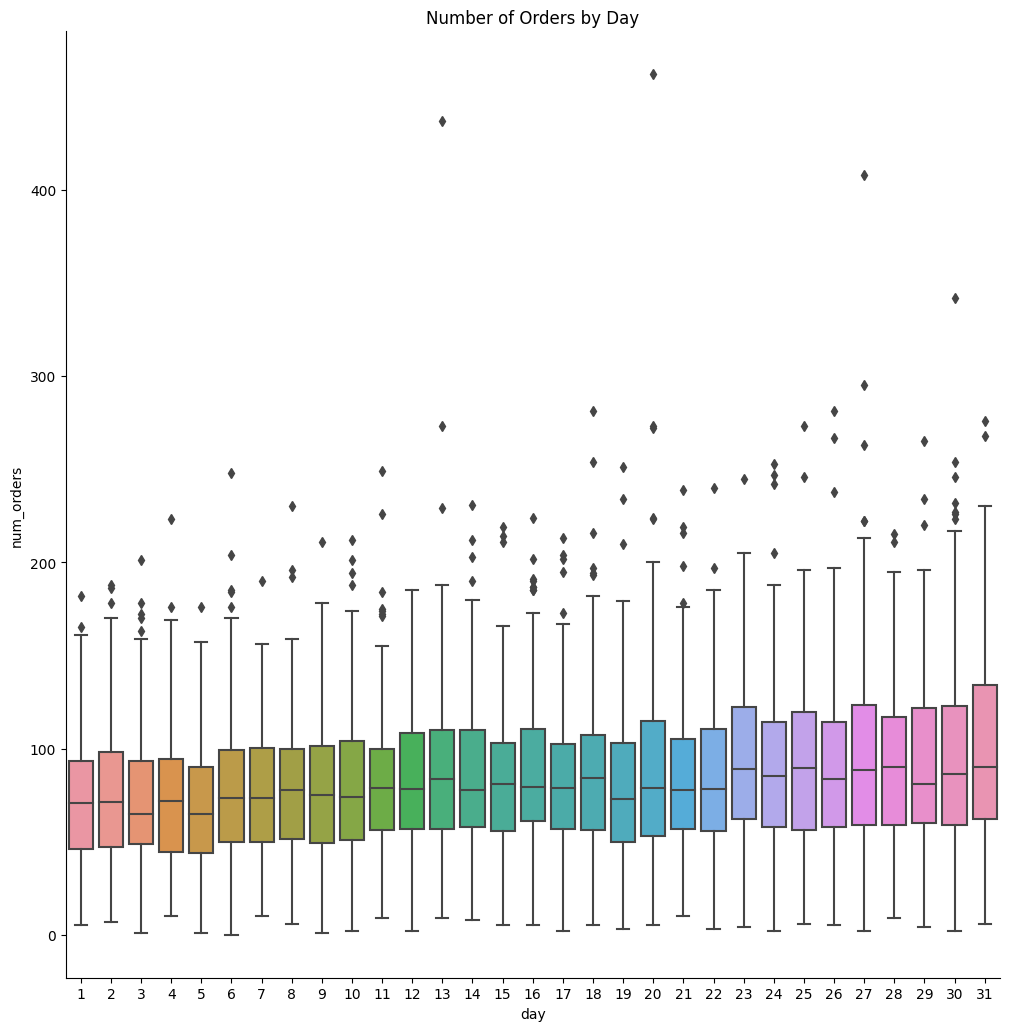

In [12]:

sns.catplot(x="month", y="num_orders", kind="box", data=data, height=10)
plt.title("Number of Orders by Month")

sns.catplot(x="weekday", y="num_orders", kind="box", data=data, height=10)
plt.title("Number of Orders by Weekday")

sns.catplot(x="hour", y="num_orders", kind="box", data=data, height=10)
plt.title("Number of Orders by Hour")

sns.catplot(x="day", y="num_orders", kind="box", data=data, height=10)
plt.title("Number of Orders by Day")


<div class="alert alert-block alert-info">

### Se crearon características adicionales: mes, día, día de la semana y hora.

1. El mes con mas ordenes es agosto
2. El dia del mes con mas ordenes es el 30
3. La hora con mas ordenes es 23:00
4. El dia de la semana con mas ordenes es el sabado

</b></div>



## 2. Pronóstico de series temporales

In [13]:

train, test = train_test_split(data, test_size=0.1, shuffle=False)
features = ['day', 'hour', 'weekday', 'month']
target = 'num_orders'
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]


In [14]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

pred_train_lr = model_lr.predict(X_train)
pred_test_lr = model_lr.predict(X_test)

recm_train_lr = np.sqrt(mean_squared_error(y_train, pred_train_lr))
recm_test_lr = np.sqrt(mean_squared_error(y_test, pred_test_lr))
r2_train_lr = r2_score(y_train, pred_train_lr)
r2_test_lr = r2_score(y_test, pred_test_lr)

print('RECM para el conjunto de entrenamiento:', recm_train_lr )
print('RECM para el conjunto de prueba:', recm_test_lr)
print('R2 para el conjunto de entrenamiento:', r2_train_lr)
print('R2 para el conjunto de prueba:', r2_test_lr)



RECM para el conjunto de entrenamiento: 34.43111380550365
RECM para el conjunto de prueba: 63.789001231137874
R2 para el conjunto de entrenamiento: 0.20709271794127382
R2 para el conjunto de prueba: -0.18698054558907962


In [15]:

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

pred_train_rf = model_rf.predict(X_train)
pred_test_rf = model_rf.predict(X_test)

recm_train_rf = np.sqrt(mean_squared_error(y_train, pred_train_rf))
recm_test_rf = np.sqrt(mean_squared_error(y_test, pred_test_rf))
r2_train_rf = r2_score(y_train, pred_train_rf)
r2_test_rf = r2_score(y_test, pred_test_rf)

print('RECM para el conjunto de entrenamiento:', recm_train_rf )
print('RECM para el conjunto de prueba:', recm_test_rf)
print('R2 para el conjunto de entrenamiento:', r2_train_rf)
print('R2 para el conjunto de prueba:', r2_test_rf)


RECM para el conjunto de entrenamiento: 8.181232301912473
RECM para el conjunto de prueba: 44.22442211138516
R2 para el conjunto de entrenamiento: 0.9552330288768422
R2 para el conjunto de prueba: 0.4294728324161924


In [16]:
#catboost


model_cb = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=10, loss_function='MAE', verbose=100)
model_cb.fit(X_train, y_train)

pred_train_cb = model_cb.predict(X_train)
pred_test_cb = model_cb.predict(X_test)

recm_train_cb = np.sqrt(mean_squared_error(y_train, pred_train_cb))
recm_test_cb = np.sqrt(mean_squared_error(y_test, pred_test_cb))
r2_train_cb = r2_score(y_train, pred_train_cb)
r2_test_cb = r2_score(y_test, pred_test_cb)

print('RECM para el conjunto de entrenamiento:', recm_train_cb )
print('RECM para el conjunto de prueba:', recm_test_cb)
print('R2 para el conjunto de entrenamiento:', r2_train_cb)
print('R2 para el conjunto de prueba:', r2_test_cb)



0:	learn: 28.1708847	total: 47.8ms	remaining: 47.8s
100:	learn: 12.3007305	total: 163ms	remaining: 1.45s
200:	learn: 9.9844442	total: 282ms	remaining: 1.12s
300:	learn: 8.7768437	total: 401ms	remaining: 930ms
400:	learn: 7.9651298	total: 524ms	remaining: 782ms
500:	learn: 7.3382442	total: 643ms	remaining: 641ms
600:	learn: 6.8364794	total: 762ms	remaining: 506ms
700:	learn: 6.4401799	total: 886ms	remaining: 378ms
800:	learn: 6.0984009	total: 1s	remaining: 250ms
900:	learn: 5.7893277	total: 1.12s	remaining: 123ms
999:	learn: 5.5402759	total: 1.25s	remaining: 0us
RECM para el conjunto de entrenamiento: 10.177245423173117
RECM para el conjunto de prueba: 51.535758385859914
R2 para el conjunto de entrenamiento: 0.9307243262980393
R2 para el conjunto de prueba: 0.2252361667959053


In [17]:

# lightgbm

model_lgbm = LGBMRegressor(n_estimators=1000, learning_rate=0.1, max_depth=10)
model_lgbm.fit(X_train, y_train)

pred_train_lgbm = model_lgbm.predict(X_train)
pred_test_lgbm = model_lgbm.predict(X_test)
recm_train_lgbm = np.sqrt(mean_squared_error(y_train, pred_train_lgbm))
recm_test_lgbm = np.sqrt(mean_squared_error(y_test, pred_test_lgbm))
r2_train_lgbm = r2_score(y_train, pred_train_lgbm)
r2_test_lgbm = r2_score(y_test, pred_test_lgbm)

print('RECM para el conjunto de entrenamiento:', recm_train_lgbm )
print('RECM para el conjunto de prueba:', recm_test_lgbm)
print('R2 para el conjunto de entrenamiento:', r2_train_lgbm)
print('R2 para el conjunto de prueba:', r2_test_lgbm)


RECM para el conjunto de entrenamiento: 11.683763047399676
RECM para el conjunto de prueba: 41.377600119462244
R2 para el conjunto de entrenamiento: 0.9086968535827116
R2 para el conjunto de prueba: 0.5005608384832261


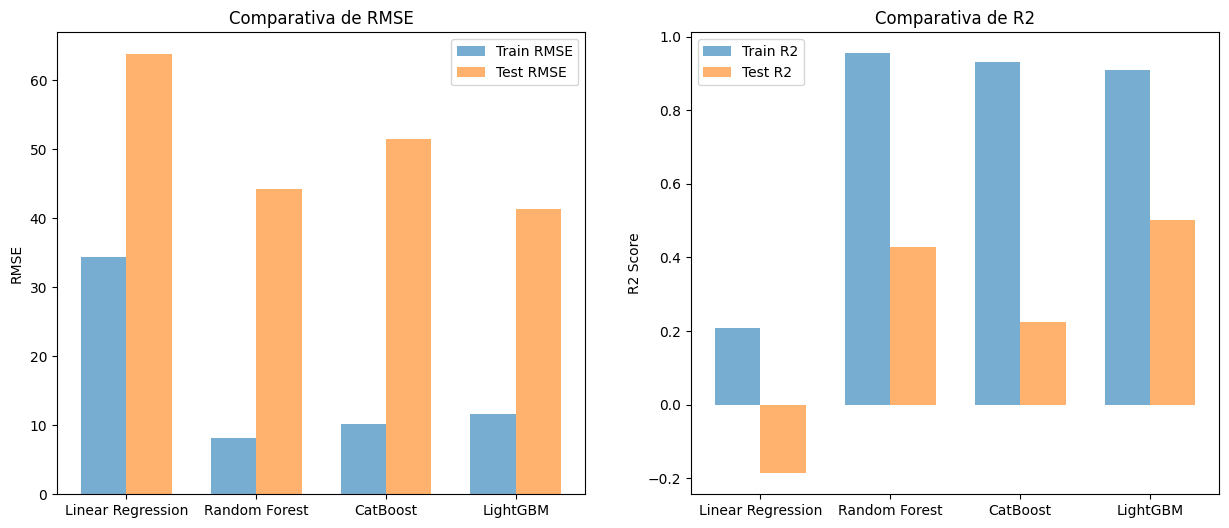

In [18]:

models = ['Linear Regression', 'Random Forest', 'CatBoost', 'LightGBM']
recm_train = [recm_train_lr, recm_train_rf, recm_train_cb, recm_train_lgbm]
recm_test = [recm_test_lr, recm_test_rf, recm_test_cb, recm_test_lgbm]
r2_train = [r2_train_lr, r2_train_rf, r2_train_cb, r2_train_lgbm]
r2_test = [r2_test_lr, r2_test_rf, r2_test_cb, r2_test_lgbm]

x = np.arange(len(models))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(15, 6))


axes[0].bar(x - width/2, recm_train, width, alpha=0.6, label='Train RMSE')
axes[0].bar(x + width/2, recm_test, width, alpha=0.6, label='Test RMSE')
axes[0].set_title('Comparativa de RMSE')
axes[0].set_ylabel('RMSE')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].legend()

# Plot R2
axes[1].bar(x - width/2, r2_train, width, alpha=0.6, label='Train R2')
axes[1].bar(x + width/2, r2_test, width, alpha=0.6, label='Test R2')
axes[1].set_title('Comparativa de R2')
axes[1].set_ylabel('R2 Score')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
axes[1].legend()

plt.show()

<div class="alert alert-block alert-info">

# Conclusiones

En este proyecto, hemos analizado los datos de la compañía Sweet Lift Taxi y hemos construido un modelo para predecir la cantidad de pedidos de taxis para la próxima hora. Hemos utilizado la métrica RECM y R2 para evaluar el rendimiento del modelo. Se ha establecido un umbral de 48 para el RMSE en el conjunto de prueba.

Hemos realizado las siguientes tareas:

1. Hemos explorado los datos y hemos encontrado que la cantidad de pedidos de taxis aumenta durante el período de estudio. También hemos encontrado que la cantidad de pedidos de taxis aumenta durante la noche.

2. Hemos creado características adicionales como mes, día, día de la semana y hora.

3. Hemos entrenado 4 modelos: Regresión lineal, Random Forest, Catboost y LightGBM.

4. Hemos evaluado los modelos utilizando la métrica RMSE y R2 en el conjunto de prueba.

5. Hemos encontrado que el modelo LightGBM tiene el menor RMSE en el conjunto de prueba.

6. Hemos concluido que el modelo LightGBM es el mejor modelo para predecir la cantidad de pedidos de taxis para la próxima hora.

</b></div>




